# 1. Importando as bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Carregamento dos dados de treino e teste

In [ ]:
train_data = pd.read_csv('treino.csv')
test_data = pd.read_csv('teste.csv')

# 3. Extração das colunas de entrada (fechamentos passados)

In [ ]:
past_close_columns = [f'Past_{i}_Days_Close' for i in range(1, 16)]
X_train = train_data[past_close_columns].values
X_test = test_data[past_close_columns].values

# 4. Escalonamento dos dados com RobustScaler

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Função para criar sequências e realizar aumento de dados com ruído

In [ ]:
def create_sequences(data, labels, time_steps=15):
    X, y = [], []
    for i in range(time_steps, len(data)):
        sequence = data[i - time_steps:i]
        X.append(sequence)
        y.append(labels[i])


        if labels[i] == 1:
            noisy_sequence = sequence + np.random.normal(0, 0.01, sequence.shape)
            X.append(noisy_sequence)
            y.append(labels[i])

    return np.array(X), np.array(y)

# 6. Criação de sequências para treino e teste

In [ ]:
X_train_seq, y_train = create_sequences(X_train_scaled, train_data['Label'].values)
X_test_seq, y_test = create_sequences(X_test_scaled, test_data['Label'].values)

# 7. Normalização de rótulos para valores binários (0 para -1 e 1 para 1)

In [ ]:
y_train = np.where(y_train == -1, 0, y_train)
y_test = np.where(y_test == -1, 0, y_test)

# 8. Cálculo de pesos de classe para lidar com desbalanceamento


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 9. Definição da arquitetura do modelo LSTM bidirecional

In [ ]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 10. Configuração do otimizador e compilação do modelo

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 11. Configuração de callbacks para EarlyStopping, Checkpoints e Redução da Taxa de Aprendizado

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# 12. Treinamento do modelo

In [ ]:
history = model.fit(
    X_train_seq, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.5172 - loss: 0.8294 - val_accuracy: 0.5440 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.5515 - loss: 0.7376 - val_accuracy: 0.7258 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.6107 - loss: 0.6771 - val_accuracy: 0.7251 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.6177 - loss: 0.6587 - val_accuracy: 0.6284 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.6687 - loss: 0.6063 - val_accuracy: 0.7193 - val_loss: 0.7271 - learning_rate: 0.0010
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.6829 - loss: 0.5868 - val_accuracy: 0.8036 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.7045 - l

# 13. Avaliação do modelo no conjunto de teste

In [ ]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print(f'Acurácia no conjunto de teste: {test_acc:.4f}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8941 - loss: 0.2678
Acurácia no conjunto de teste: 0.8980


# 14. Previsão e cálculo do limiar para classificação binária

In [ ]:
y_pred_proba = model.predict(X_test_seq)
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


# 15. Criação e exibição da matriz de confusão

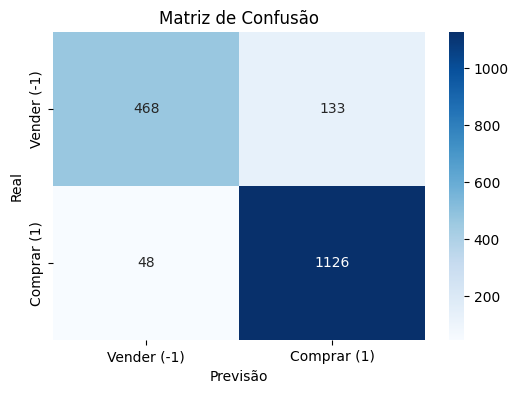

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Vender (-1)', 'Comprar (1)'],
            yticklabels=['Vender (-1)', 'Comprar (1)'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# 16. Cálculo e exibição de métricas de avaliação

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Vender (-1)', 'Comprar (1)']))

Precisão: 0.8944
Recall: 0.9591
F1-Score: 0.9256

Relatório de Classificação:
              precision    recall  f1-score   support

 Vender (-1)       0.91      0.78      0.84       601
 Comprar (1)       0.89      0.96      0.93      1174

    accuracy                           0.90      1775
   macro avg       0.90      0.87      0.88      1775
weighted avg       0.90      0.90      0.90      1775

